# Accessing and plotting Whole Mouse Brain (WMB) 10x RNA-seq gene expression data

For this workshop, we provide a notebook concatenating examples using the single-cell transcriptomic Whole Mouse Brain (WMB). Full examples using the data can be found in the notebooks listed [here](https://alleninstitute.github.io/abc_atlas_access/descriptions/notebook_subtitle1.html).

This notebook provides examples and functions for accessing taxonomy, expression matrix data, and creating UMAP and heatmap plots. We also show a quick example of how to combine cells selected in an ABC Atlas visualization and these data. These examples are presented in the context of investigating the celltype subclass, L5 ET CTX Glut. We'll start by loading gene expression for this celltype's marker genes and then plotting the celltype and expression in a UMAP and heatmap using some simple helper functions. From there we'll show a quick example of combining a set of cells selected in the ABC Atlas with our data here. For the full set of example notebooks and explanations  of the data available, see the [ABC Atlas Access website](https://alleninstitute.github.io/abc_atlas_access/intro.html).

Note that some of these files require a large amount of harddrive space and memory to be available to load and analyze them if care is not taken. We'll use a convenience function that is part of the `abc_atlas_access` to access gene expression data. 

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache
from abc_atlas_access.abc_atlas_cache.anndata_utils import get_gene_data

We will interact with the data using the **AbcProjectCache**. This cache object tracks which data has been downloaded and serves the path to the requested  data on disk. For metadata, the cache can also directly serve up a Pandas DataFrame. See the ``getting_started`` notebook for more details on using the cache including installing it if it has not already been.

**Change the download_base variable to where you have downloaded the data in your system.**

In [7]:
download_base = Path('../../data/abc_atlas')
abc_cache = AbcProjectCache.from_s3_cache(download_base)
abc_cache.current_manifest

'releases/20250131/manifest.json'

## Gene expression matrices

The WMB dataset and other datasets available through `abc_atlas_access` are formatted similarly. Each package contains annadata h5ad files with minimal metadata stored in their `obs` and `var` attributes. The majority of the metadata (e.g. cell metadata, genes, and taxonomy information) are stored in csv files separately. With a few exceptions, all datasets provide two h5ad gene expression files: one storing the raw counts and the other a log2 normalization of the counts.

For our example we will load the WMB datasets. We first need to load two pieces of metadata from our instantiated AbcProjectCache object, the ``cell``s table and the ``gene``s table. These metadata can be found in the directories WMB-10X for mouse. For the other datasets, these files are stored similarly near the h5ad files through refer to the appropriate data and example notebook pages for the individual dataset.

The cell metadata file we load below already has cluster information merged into it. To see how to perform this process, refer to [this notebook](https://alleninstitute.github.io/abc_atlas_access/notebooks/cluster_annotation_tutorial.html).

In [8]:
cell = abc_cache.get_metadata_dataframe(
    directory='WMB-10X',
    file_name='cell_metadata_with_cluster_annotation'
).set_index('cell_label')
print(f"Number of cells {len(cell)}")
cell.head()

/Users/chris.morrison/src/miniconda3/envs/abc_atlas_access/lib/python3.12/site-packages/abc_atlas_access/abc_atlas_cache/abc_project_cache.py:429: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(path, **kwargs)


Number of cells 4042976


,cell_barcode,barcoded_cell_sample_label,library_label,feature_matrix_label,entity,brain_section_label,library_method,region_of_interest_acronym,donor_label,donor_genotype,...,subclass,supertype,cluster,neurotransmitter_color,class_color,subclass_color,supertype_color,cluster_color,region_of_interest_order,region_of_interest_color
cell_label,,,,,,,,,,,,,,,,,,,,,
GCGAGAAGTTAAGGGC-410_B05,GCGAGAAGTTAAGGGC,410_B05,L8TX_201030_01_C12,WMB-10Xv3-HPF,cell,NaN,10Xv3,RHP,Snap25-IRES2-Cre;Ai14-550850,Ai14(RCL-tdT)/wt,...,018 L2 IT PPP-APr Glut,0082 L2 IT PPP-APr Glut_3,0326 L2 IT PPP-APr Glut_3,#2B93DF,#FA0087,#0F6632,#266DFF,#64661F,15,#CCB05C
AATGGCTCAGCTCCTT-411_B06,AATGGCTCAGCTCCTT,411_B06,L8TX_201029_01_E10,WMB-10Xv3-HPF,cell,NaN,10Xv3,RHP,Snap25-IRES2-Cre;Ai14-550851,Ai14(RCL-tdT)/wt,...,018 L2 IT PPP-APr Glut,0082 L2 IT PPP-APr Glut_3,0326 L2 IT PPP-APr Glut_3,#2B93DF,#FA0087,#0F6632,#266DFF,#64661F,15,#CCB05C
AACACACGTTGCTTGA-410_B05,AACACACGTTGCTTGA,410_B05,L8TX_201030_01_C12,WMB-10Xv3-HPF,cell,NaN,10Xv3,RHP,Snap25-IRES2-Cre;Ai14-550850,Ai14(RCL-tdT)/wt,...,018 L2 IT PPP-APr Glut,0082 L2 IT PPP-APr Glut_3,0326 L2 IT PPP-APr Glut_3,#2B93DF,#FA0087,#0F6632,#266DFF,#64661F,15,#CCB05C
CACAGATAGAGGCGGA-410_A05,CACAGATAGAGGCGGA,410_A05,L8TX_201029_01_A10,WMB-10Xv3-HPF,cell,NaN,10Xv3,RHP,Snap25-IRES2-Cre;Ai14-550850,Ai14(RCL-tdT)/wt,...,018 L2 IT PPP-APr Glut,0082 L2 IT PPP-APr Glut_3,0326 L2 IT PPP-APr Glut_3,#2B93DF,#FA0087,#0F6632,#266DFF,#64661F,15,#CCB05C
AAAGTGAAGCATTTCG-410_B05,AAAGTGAAGCATTTCG,410_B05,L8TX_201030_01_C12,WMB-10Xv3-HPF,cell,NaN,10Xv3,RHP,Snap25-IRES2-Cre;Ai14-550850,Ai14(RCL-tdT)/wt,...,018 L2 IT PPP-APr Glut,0082 L2 IT PPP-APr Glut_3,0326 L2 IT PPP-APr Glut_3,#2B93DF,#FA0087,#0F6632,#266DFF,#64661F,15,#CCB05C


In [9]:
gene = abc_cache.get_metadata_dataframe(directory='WMB-10X', file_name='gene').set_index('gene_identifier')
gene.head()

,gene_symbol,name,mapped_ncbi_identifier,comment
gene_identifier,,,,
ENSMUSG00000051951,Xkr4,X-linked Kx blood group related 4,NCBIGene:497097,NaN
ENSMUSG00000089699,Gm1992,predicted gene 1992,NaN,NaN
ENSMUSG00000102331,Gm19938,"predicted gene, 19938",NaN,NaN
ENSMUSG00000102343,Gm37381,"predicted gene, 37381",NaN,NaN
ENSMUSG00000025900,Rp1,retinitis pigmentosa 1 (human),NCBIGene:19888,NaN


### Loading L5 ET CTX Glut marker genes from the data

The WMB dataset consists of a set of files split across assay and dissection region. The files are fairly large in size with many being close to 10GB. Loading all the data into memory would use up too many recourses at laptop scale. To avoid this, we load the data in chunks and recombine them into a pandas DataFrame with all cells and the requested genes loaded.

Below, we specify a select set of genes from the data that we'll load into our output data frame. These are marker genes for the sub levels of the taxonomy subclass, L5 ET CTX Glut. There is another sample of genes available in the  ``example_genes_all_cells_expression`` that is used in [this section of the  WMB gene expression tutorial](https://alleninstitute.github.io/abc_atlas_access/notebooks/10x_snRNASeq_tutorial_part_2b.html). However, here we use marker genes from the aforementioned taxonomy subclass and save our output to disk.

For a more in-depth demo describing how to extract gene expression data from our h5ad files, [see this demo notebook](https://alleninstitute.github.io/abc_atlas_access/notebooks/general_accessing_10x_snRNASeq_tutorial.html).

In [10]:
gene_names = ['Crym', 'Npsr1', 'Erg', 'Trpc7', 'Reln']

Below is a function that can be used to load specific genes from the from the full set of data from any of the 10X datasets. Adjust the chunk size down if you find your system still running out of memory. Additionally, reduce the number of genes if you still have issues. Note that the function can load either the raw expression data or the log2 data. The full code of this function can be found [here](https://github.com/AllenInstitute/abc_atlas_access/blob/7a53a08cff0f07e9b67911c0db04fa6932fa6e9d/src/abc_atlas_access/abc_atlas_cache/anndata_utils.py#L9)

In [11]:
?get_gene_data

Signature:
get_gene_data(
    abc_atlas_cache: abc_atlas_access.abc_atlas_cache.abc_project_cache.AbcProjectCache,
    all_cells: pandas.core.frame.DataFrame,
    all_genes: pandas.core.frame.DataFrame,
    selected_genes: List[str],
    data_type: str = 'log2',
    chunk_size: int = 8192,
)
Docstring:
Load expression matrix data from the ABC Atlas and extract data for
specific genes.

Method will load all expression data required to process across multiple
files to extract the full set of genes. This may result in downloading
potentially ~100 GB of data.

Parameters
----------
abc_atlas_cache: AbcProjectCache
    An AbcProjectCache instance object to handle downloading and serving
    the path to the expression matrix data.
all_cells: pandas.DataFrame
    cells metadata loaded as a pandas Dataframe from the AbcProjectCache
    indexed on cell_label.
all_genes: pandas.DataFrame
    genes metadata loaded as a pandas Dataframe from the AbcProjectCache
    indexed on gene_identifier.
sele

The code below will create a gene expression DataFrame over the full WMB dataset. Running this full process takes around ~10 minutes to processes, however downloading the full data can take up to a few hours depending on your download speed. 

In [14]:
gene_data = get_gene_data(
    abc_atlas_cache=abc_cache,
    all_cells=cell,
    all_genes=gene,
    selected_genes=gene_names,
    chunk_size=8192
)

loading file: WMB-10XMulti
 - time taken:  2.161857999999995
loading file: WMB-10Xv2-CTXsp
 - time taken:  8.789330000000007
loading file: WMB-10Xv2-HPF
 - time taken:  39.09307
loading file: WMB-10Xv2-HY
 - time taken:  17.374981000000005
loading file: WMB-10Xv2-Isocortex-1
 - time taken:  42.45327499999999
loading file: WMB-10Xv2-Isocortex-2
 - time taken:  47.75744800000001
loading file: WMB-10Xv2-Isocortex-3
 - time taken:  48.73720900000001
loading file: WMB-10Xv2-Isocortex-4
 - time taken:  48.465873999999985
loading file: WMB-10Xv2-MB
 - time taken:  5.518642999999997
loading file: WMB-10Xv2-OLF
 - time taken:  35.42446799999999
loading file: WMB-10Xv2-TH
 - time taken:  25.227839999999958
loading file: WMB-10Xv3-CB
 - time taken:  32.825334
loading file: WMB-10Xv3-CTXsp
 - time taken:  15.109788000000037
loading file: WMB-10Xv3-HPF
 - time taken:  34.37726500000002
loading file: WMB-10Xv3-HY
 - time taken:  30.54253699999998
loading file: WMB-10Xv3-Isocortex-1
 - time taken:  4

In [15]:
gene_data

gene_symbol,Reln,Crym,Npsr1,Trpc7,Erg
cell_label,,,,,
GCGAGAAGTTAAGGGC-410_B05,0.0,0.0,0.0,0.0,0.0
AATGGCTCAGCTCCTT-411_B06,0.0,5.980985,7.381675,0.0,0.0
AACACACGTTGCTTGA-410_B05,4.522213,0.0,0.0,0.0,0.0
CACAGATAGAGGCGGA-410_A05,0.0,0.0,0.0,0.0,0.0
AAAGTGAAGCATTTCG-410_B05,0.0,6.052556,0.0,6.052556,0.0
...,...,...,...,...,...
GTGTGAGCAAACGCGA-1350_C05,8.891156,0.0,0.0,0.0,0.0
TTAGCAATCCCTGTTA-1350_C05,0.0,0.0,0.0,0.0,0.0
TTTGGCTGTCGCGCAA-1350_C05,0.0,0.0,0.0,0.0,0.0


The returned DataFrame is indexed by ``cell_label`` and can thus be joined with the ``cell`` DataFrame for further analysis. Below we save the set of genes we selected for later use.

In [16]:
gene_data.to_csv('workshop_demo_genes.csv')

### Plotting Gene expression in L5 ET CTX Glut

Now that we have our gene expression data, we can merge it into the cell metadata table and use the added data in further analysis. Below we load our previously saved gene expression data and merge it with our already loaded cell metadata table.

In [17]:
gene_data = pd.read_csv('workshop_demo_genes.csv').set_index('cell_label')
cell_with_genes = cell.join(gene_data)

We pair down the number of cells we are plotting by a factor of ten make plotting snappier.

In [18]:
cell_subsampled = cell_with_genes[::10]

Below is an example function to plot a UMAP of cells. This function can either be used to plot the full set of cells colored either by one of the "color" columns (e.g. `supertype_color` or `region_of_interest_color`) or values from the frame such as the gene expression values we just computed. The plot can be created with only a specific cell type taxon selected. This can be useful for visualizing gene expression for just a single taxon, for instance.

In [19]:
def plot_umap_with_taxonomy_selection(
    input_df,
    cc_column=None,
    val_column=None,
    cc_value=None,
    cell_type_taxon=None,
    fig_width=8,
    fig_height=8,
    cmap=None,
    use_background=False,
    fig=None,
    ax=None
):
    """Plot the UMAP data as a scatter plot.

    Parameters
    ----------
    input_df: pandas.DataFrame
        Cell metadata table with cell taxonomy data per-cell.
    cc_column: str
        Name of the color column to plot. Use this or val_column to color UMAP.
    val_column: str
        Name of the column to use as the values in a color map.
        Use this or cc_column to color UMAP.
    cc_value: str
        Set all cells shown to a single color value. Overrides
        cc_column and val_column settings.
    cell_type_taxon: List[str, str]
        Pair of taxonomy level and cell type taxon name to subselect data.
        Use as for example ``cell_type_taxon=['subclass', '022 L5 ET CTX Glut']``
    fig_width: int
        Width of the figure to produce. Default 8
    fig_height: int
        Height of the figure to produce. Default 4
    cmap: matplotlib.colors.ListedColormap
        Colormap of the plot. Default None.
    use_background: bool
        Plot a grey background of all other data not selected. Not used if not
        specifying a cell_type_taxon.
        
    """

    if fig is None or ax is None:
        fig, ax = plt.subplots()
        fig.set_size_inches(fig_width, fig_height)

    if cell_type_taxon is None:
        plot_df = input_df
    else:
        plot_df = input_df[input_df[cell_type_taxon[0]] == cell_type_taxon[1]]
        if use_background:
            background_frame = input_df[input_df[cell_type_taxon[0]] != cell_type_taxon[1]]
            plt.scatter(background_frame['x'], background_frame['y'], s=0.5, color='#D3D3D3', marker='.')
    if cc_value is not None:
        plt.scatter(plot_df['x'], plot_df['y'], s=0.5, color=cc_value, marker='.')
    elif val_column is not None:
        if cmap is None:
            cmap = plt.cm.magma_r
        plt.scatter(plot_df['x'], plot_df['y'], s=0.5, c=plot_df[val_column], marker='.', cmap=cmap)
    elif cc_column is not None:
        plt.scatter(plot_df['x'], plot_df['y'], s=0.5, color=plot_df[cc_column], marker='.')
    else:
        raise ValueError("Specify either a cc_column name or val_column from the cell metadata table.")
        
    ax.axis('equal')
    ax.set_xlim(-18, 27)
    ax.set_ylim(-18, 27)
    ax.set_xticks([])
    ax.set_yticks([])
    
    return fig, ax

We now plot all the subclasses in the data with their colors specified by the subclass_color column. The cell type taxon we are interested in, 022 L5 ET CTX Glut, can be seen on the right-hand side of the plot in light blue. This is shown in the next after the subclass plot.

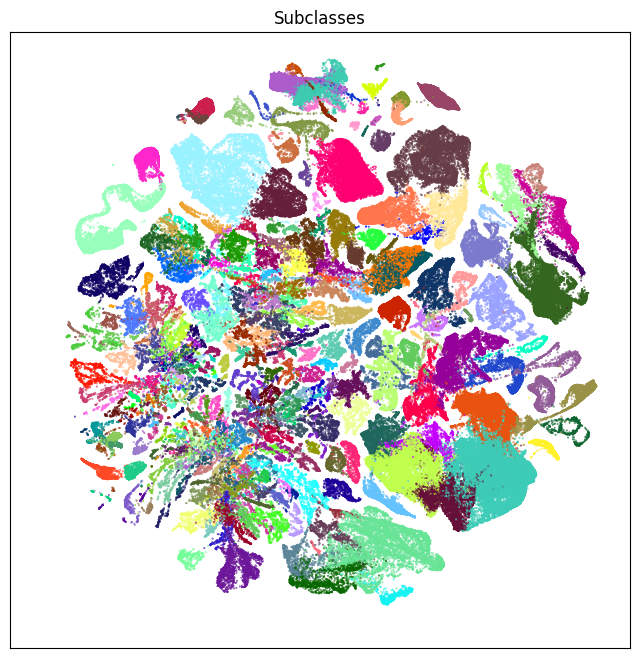

In [20]:
fig, ax = plot_umap_with_taxonomy_selection(cell_subsampled, cc_column='subclass_color')
res = ax.set_title(f"Subclasses")

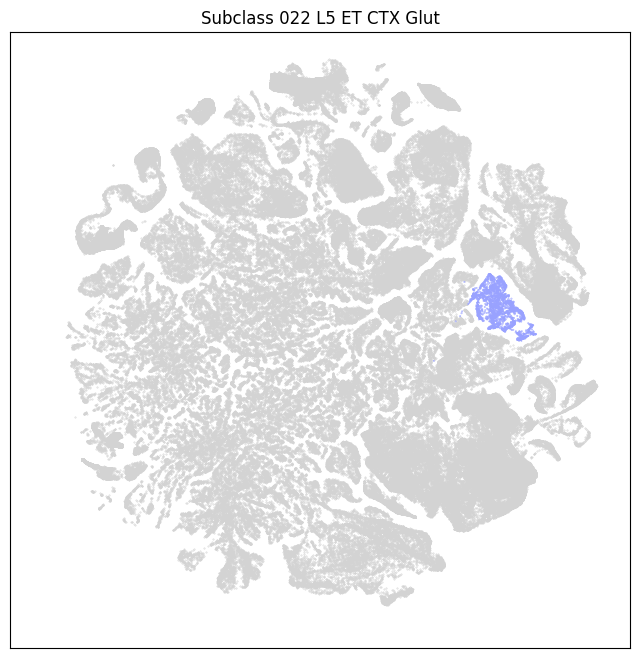

In [21]:
fig, ax = plot_umap_with_taxonomy_selection(
    cell_subsampled,
    cc_column='subclass_color',
    cell_type_taxon=['subclass', '022 L5 ET CTX Glut'],
    use_background=True
)
res = ax.set_title(f"Subclass 022 L5 ET CTX Glut")

Now that we can select a specific cell type taxon, we can plot the expression of our selected marker genes in that taxon, L5 ET CTX Glut. We plot each gene in turn, with darker colors representing more expression, and fainter colors denoting less expression. You can clearly see how the different genes are expressed in different regions in the UMAP even within the single cell type taxon.

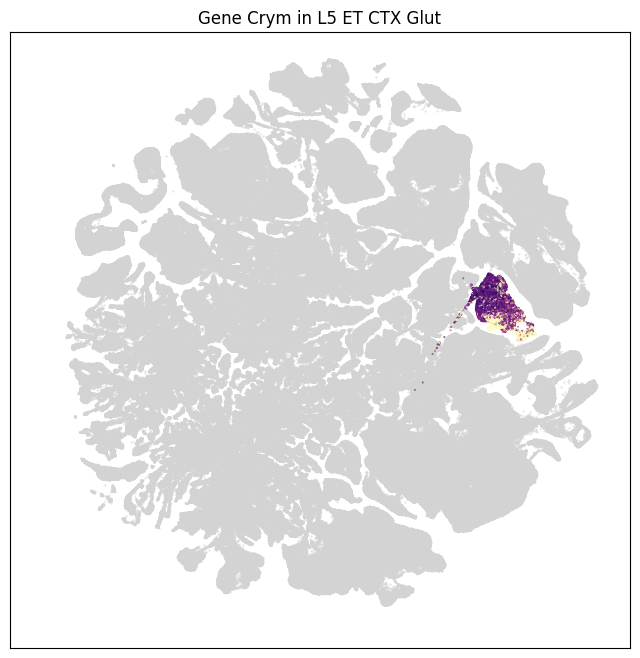

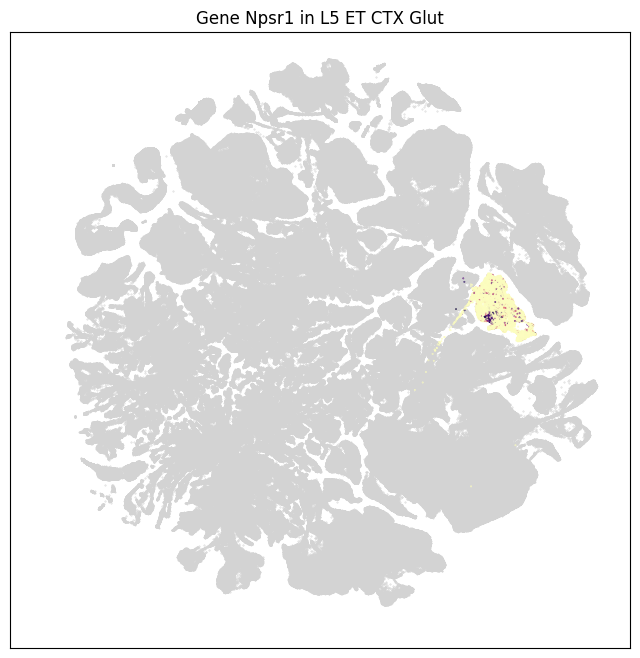

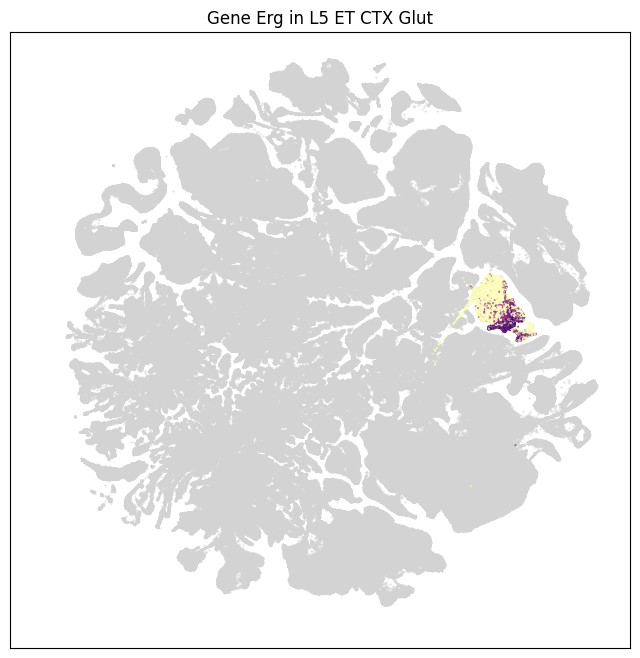

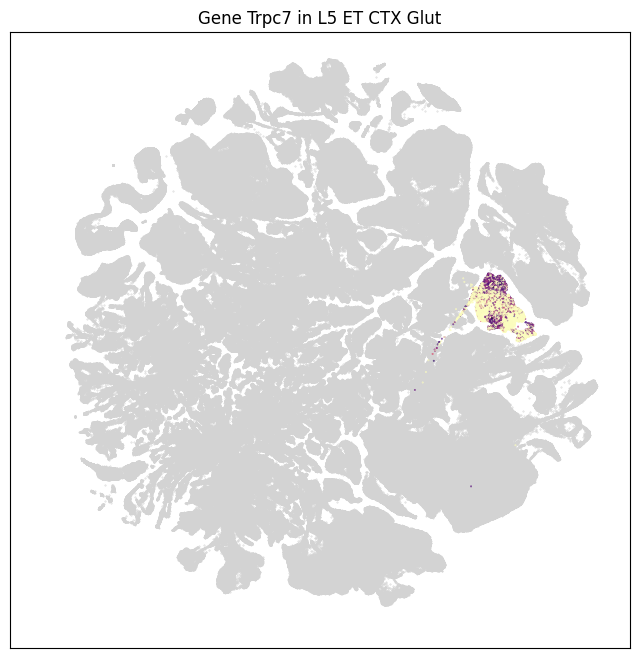

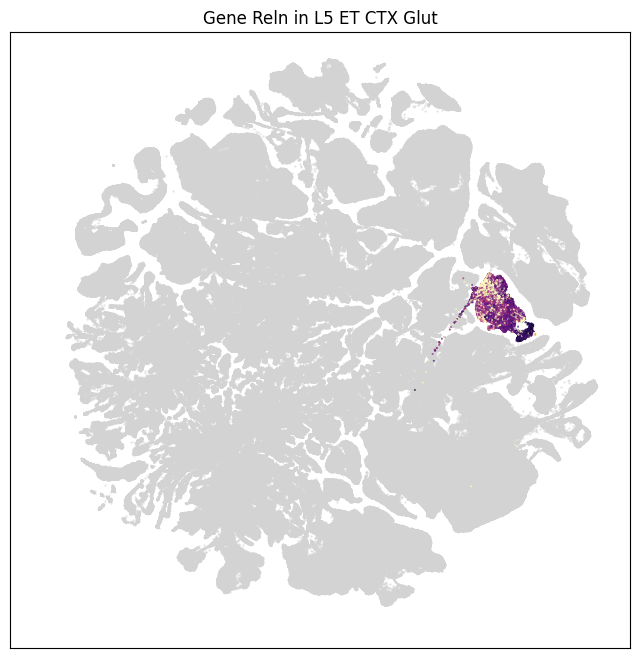

In [22]:
for gene in gene_names:
    fig, ax = plot_umap_with_taxonomy_selection(
        cell_with_genes,
        val_column=gene,
        cell_type_taxon=['subclass', '022 L5 ET CTX Glut'],
        cmap=plt.cm.magma_r,
        use_background=True
    )
    res = ax.set_title(f"Gene {gene} in L5 ET CTX Glut")

#### Plotting as a heatmap

Below we define two functions to help us plot our gene expression data in a heatmap against various other metadata quantities. The first function takes in our cell metadata table with gene expressions and averages the gene expression as a function of a specific column over the cells. For example, you could compute the average of the gene expression as a function of neurotransmitter type. We will use these functions to show the expression of our marker genes across the different supertypes below the L5 ET CTX Glut cell type.

In [23]:
def aggregate_by_metadata(df, gnames, value, sort=False):
    """Return a set of gene expressions averaged across all cells for each unique
    instance in the column specificed by value.

    Parameters
    ----------
    df: pandas.DataFrame
        Cell metadata dataframe.
    gnames: list[str]
        List of string names of the gene symbols to average their expression.
    value: str
        Name of the column to average gene expressions over cells. Creates a valueXgene table.
    sort: bool
        Sort the resultant DataFrame. Default False.
    """
    grouped = df.groupby(value)[gnames].mean()
    if sort:
        grouped = grouped.sort_values(by=gnames[0], ascending=False)
    return grouped


def plot_heatmap(df, fig_width = 8, fig_height = 4, cmap=plt.cm.magma_r, vmax=None):
    """
    Plot a heatmap of gene expression by another summarized quantity.

    Parameters
    ----------
    df: pandas.DataFrame
        Cell metadata dataframe run through the aggrgate_by_metadata function.
    fig_width: int
        Width of the figure to produce. Default 8
    fig_height: int
        Height of the figure to produce. Default 4
    cmap: matplotlib.colors.ListedColormap
        Colormap of the plot. Default default magma_r.
    vmax: Optional int
        Max value to clip data to. Defaults to None.
    """
    arr = df.to_numpy()

    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)

    res = ax.imshow(arr, cmap=cmap, aspect='auto', vmax=vmax)
    xlabs = df.columns.values
    ylabs = df.index.values

    ax.set_xticks(range(len(xlabs)))
    ax.set_xticklabels(xlabs)

    ax.set_yticks(range(len(ylabs)))
    res = ax.set_yticklabels(ylabs)

We first select the specific subclass we are interested in from our cell metadata table, then average the gene expression across each of the supertype sand finally plot the resultant DataFrame as a heatmap. The spatial structure we saw in the gene expression above is reflected in heatmap as certain supertypes express the marker genes more strongly than others.

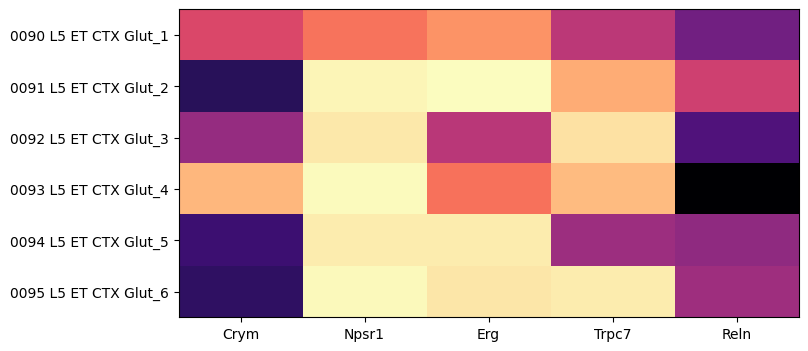

In [24]:
l5_et_ctx_glut_df = cell_with_genes[cell_with_genes['subclass'] == '022 L5 ET CTX Glut']
agg = aggregate_by_metadata(l5_et_ctx_glut_df, gene_names, 'supertype') # aggregate the gene expression by taxonomy supertype.
plot_heatmap(df=agg, fig_width=8, fig_height=4) # Plot the heatmap of gene expression by supertype.

Here we show the values in the data we plotted above.

In [25]:
agg

,Crym,Npsr1,Erg,Trpc7,Reln
supertype,,,,,
0090 L5 ET CTX Glut_1,3.374999,2.454976,1.922135,4.008305,5.412898
0091 L5 ET CTX Glut_2,6.808655,0.273587,0.141123,1.523048,3.622363
0092 L5 ET CTX Glut_3,4.695799,0.502764,4.024505,0.632997,6.062836
0093 L5 ET CTX Glut_4,1.324999,0.178836,2.472026,1.259556,8.063895
0094 L5 ET CTX Glut_5,6.445231,0.429977,0.429120,4.571800,4.827199
0095 L5 ET CTX Glut_6,6.692049,0.214090,0.517765,0.430044,4.558259


This can also be done with finer grained taxonomy levels or any other column in the cell metadata table for instance neurotransmitter or dissection region of interest. Below is the same L5 ET CTX Glut superclass we selected above but now plotting all its clusters, the lowest level in the taxonomy. 

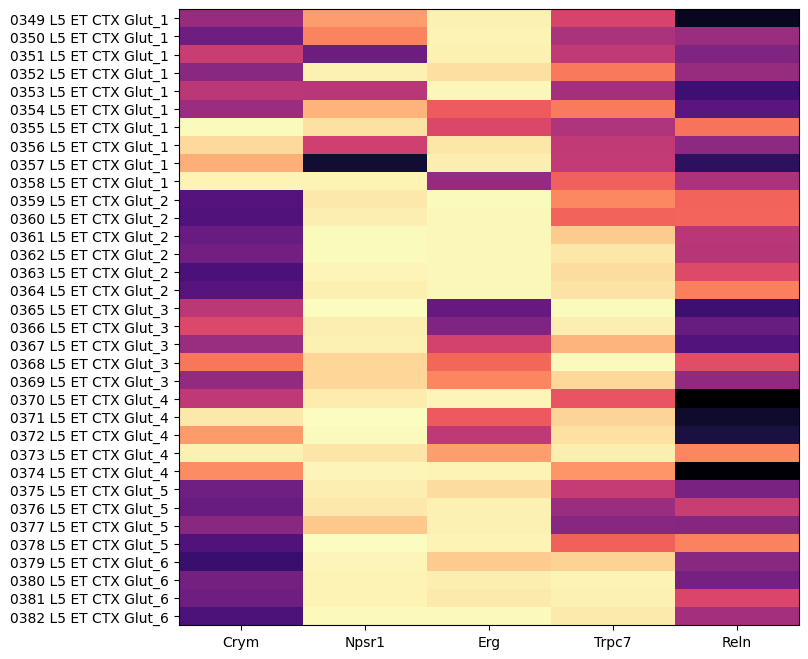

In [26]:
agg = aggregate_by_metadata(l5_et_ctx_glut_df, gene_names, 'cluster')
plot_heatmap(df=agg, fig_width=8, fig_height=8)

For more examples, visit the [ABC Atlas Access](https://alleninstitute.github.io/abc_atlas_access/intro.html) website. There you'll find Jupyter notebook tutorials on working with other datasets such as the [Whole Human Brain](https://alleninstitute.github.io/abc_atlas_access/descriptions/WHB_notebooks.html), the [Aging Mouse Brain dataset](https://alleninstitute.github.io/abc_atlas_access/descriptions/Zeng_Aging_Mouse_notebooks.html), as well as examples working with [MERFISH](https://alleninstitute.github.io/abc_atlas_access/descriptions/notebook_subtitle3.html) [data](https://alleninstitute.github.io/abc_atlas_access/descriptions/notebook_subtitle4.html) and more.

## Combining with a selection from an ABC Atlas Visualization

In this example, we'll show how you can combine the data we've presented in this tutorial with data selected from the ABC Atlas visualization tool.

In the image below, we've selected a subset of cells that are members of the L5 ET CTX Glut subclass from the [WMB UMAP visualization](https://knowledge.brain-map.org/abcatlas#AQEBQVA4Sk5ONUxZQUJHVk1HS1kxQgACUTFOQ1dXUEc2RlowRE5JWEpCUQADBAFGUzAwRFhWMFQ5UjFYOUZKNFFFAAIAAAFRWTVTOEtNTzVITEpVRjBQMDBLAAIBMDIyIEw1IEVUIENUWCBHbHV0AAABMTVCSzQ3RENJT0YxU0xMVVc5UAACAAABQ0JHQzBVMzBWVjlKUFI2MFRKVQACAAAEAQECgxgkK4Fcs4sDgORfCICuwEIABQAGAQECMTVCSzQ3RENJT0YxU0xMVVc5UAADfgAAAAQAAAhHNEk0R0ZKWEpCOUFUWjNQVFgxAAlMVkRCSkFXOEJJNVlTUzFRVUJHAAoACwFub25lAAJub25lAAMBBAEAAiMwMDAwMDAAA8gBAAUBAQIjMDAwMDAwAAPIAQAAAAIBAA%3D%3D). We can see that this includes 84 cells from one of the supertypes in the subclass.

**Important Note: the limit for the number of cells one can download in this way from the ABC Atlas is 100.**

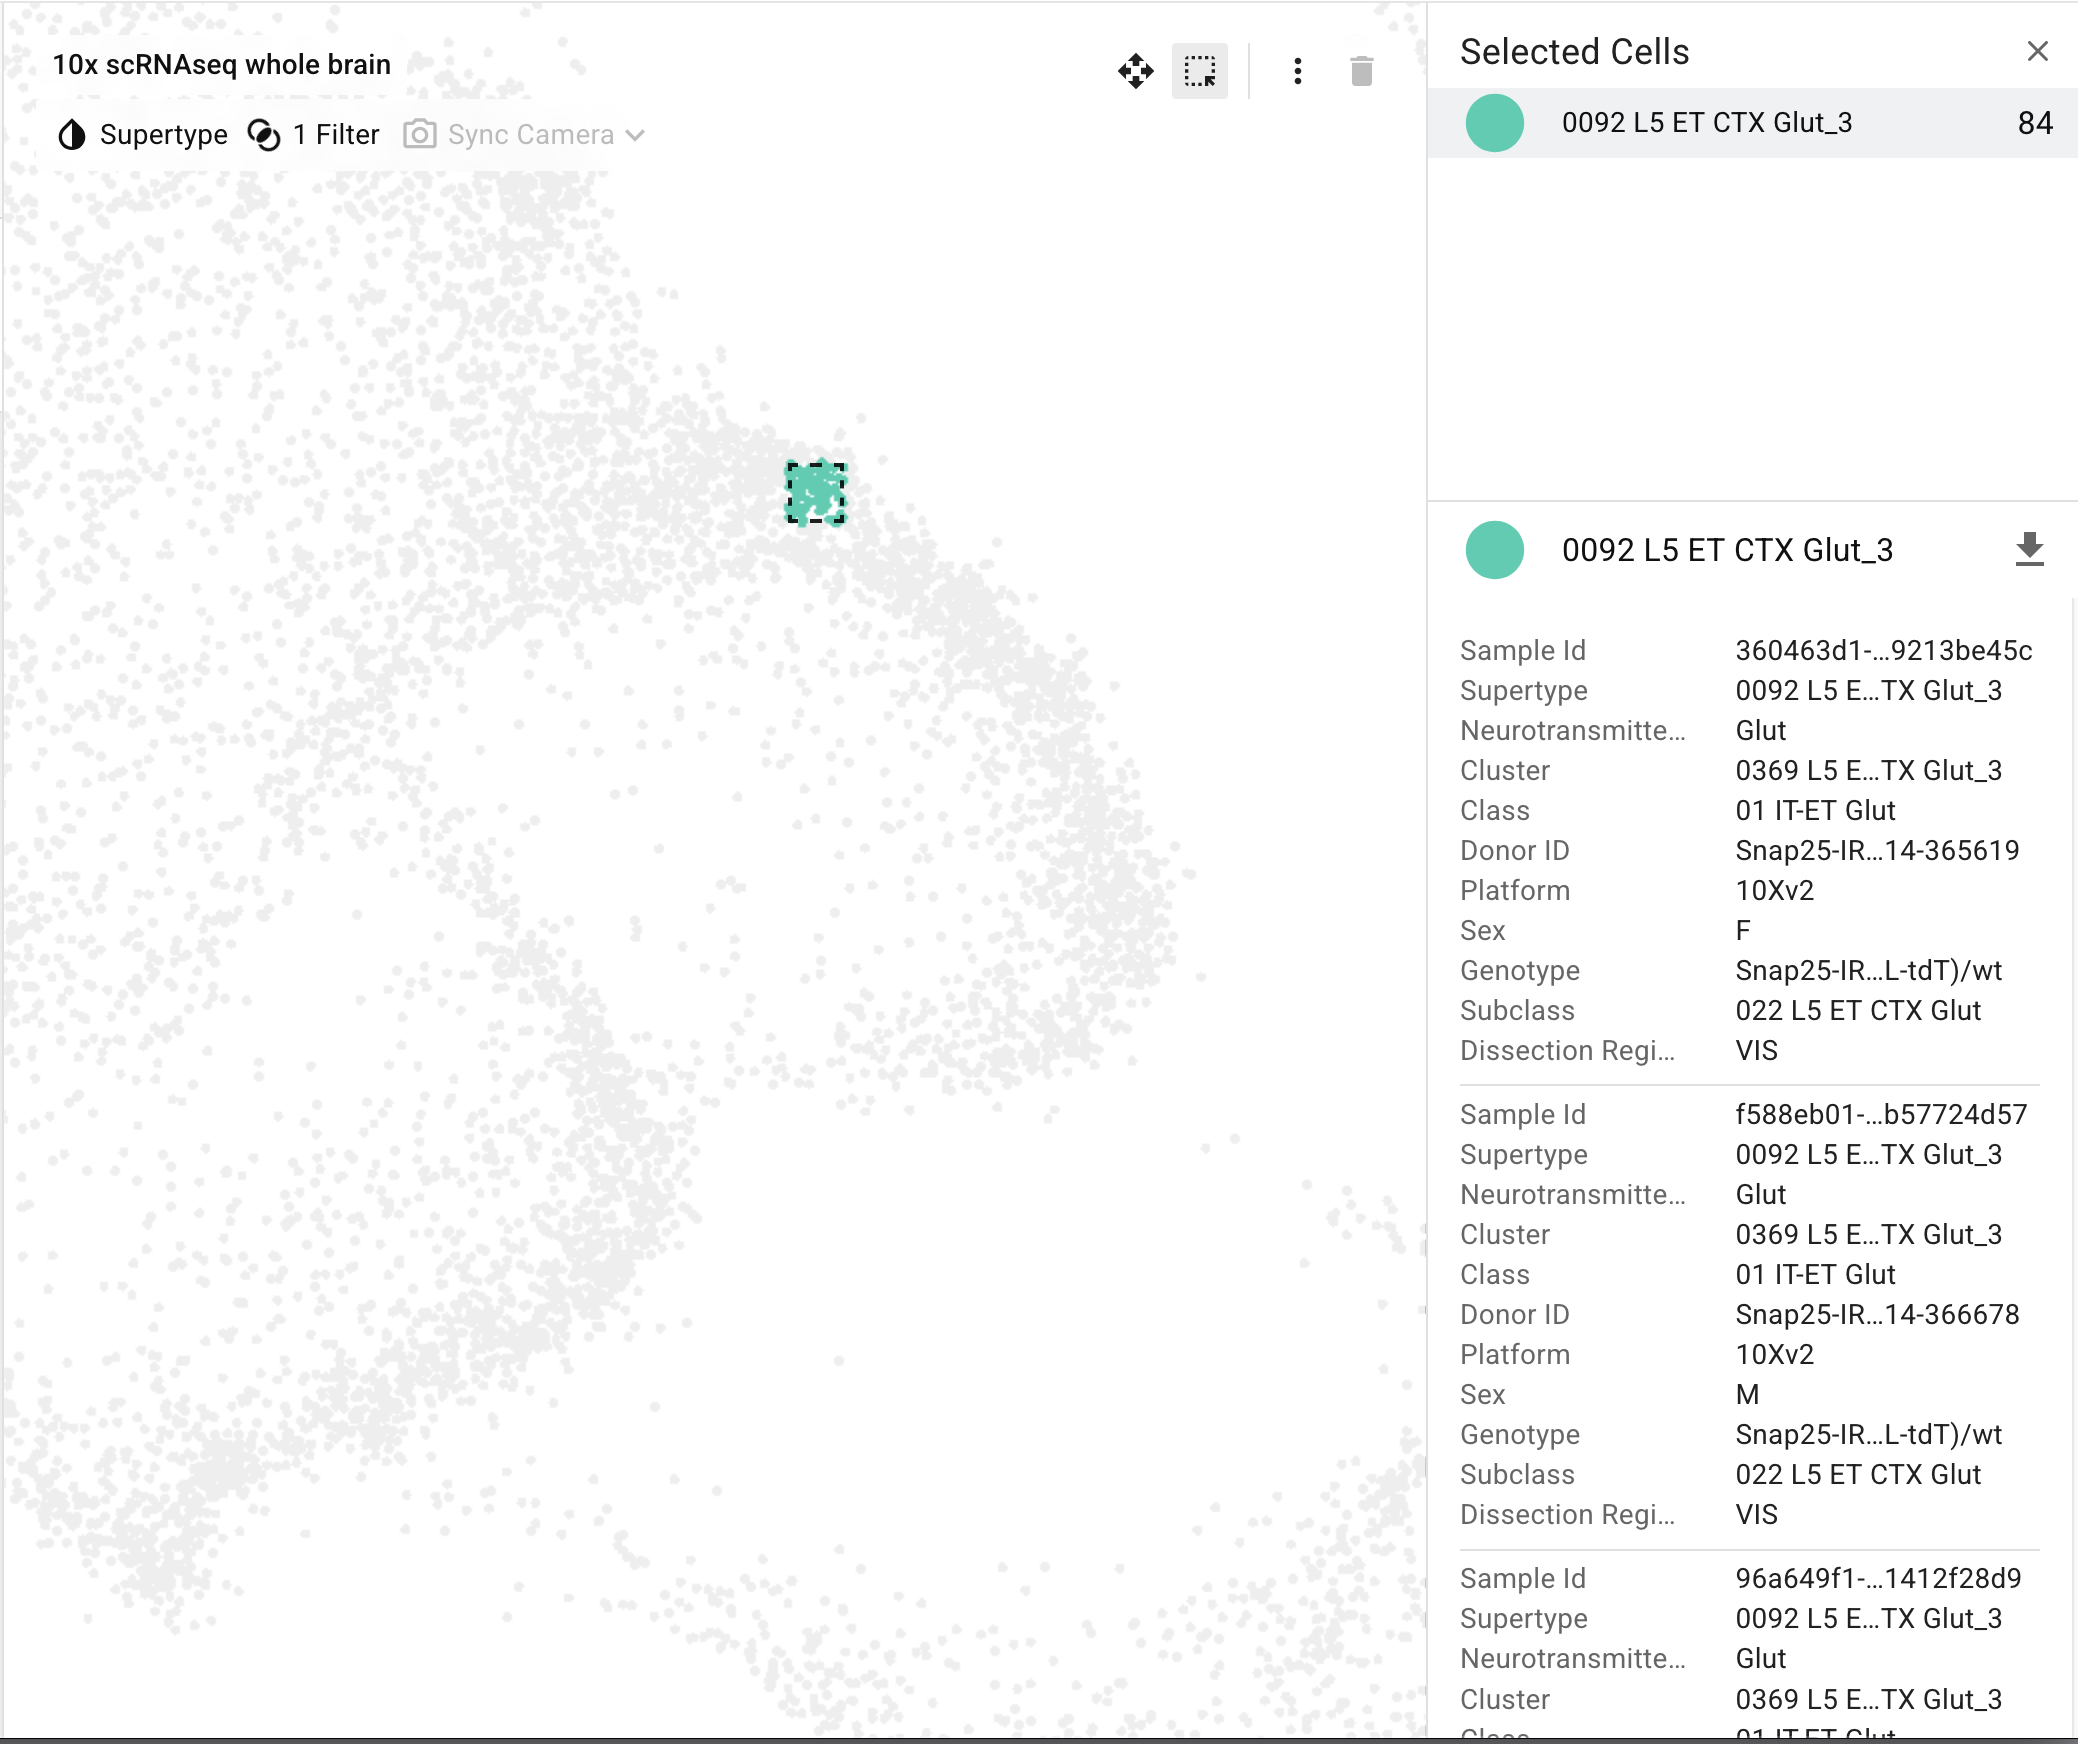

In [27]:
from PIL import Image
image = Image.open('example_selection.png')
image

Now that we have our cells selected and downloaded, let's take a look at the data produced.

The first thing we'll notice is that while there is some metadata in the file we downloaded, it does not have the same id as our metadata. The column `Sample Id` is the unique identifier of the cell in the ABC Atlas. Fortunately, this id is available in our cell metadata table as `abc_sample_id` (more on that in a moment).

In [28]:
selected_abc_atlas_cells = pd.read_csv('demo_abc_atlas_selection.csv')
selected_abc_atlas_cells.head()

,Sample Id,Supertype,Neurotransmitter Type,Cluster,Class,Donor ID,Platform,Sex,Genotype,Subclass,Dissection Region
0,dc2d2908-1d29-4690-8238-5a26b5fb9d5e,0092 L5 ET CTX Glut_3,Glut,0369 L5 ET CTX Glut_3,01 IT-ET Glut,Snap25-IRES2-Cre;Ai14-366678,10Xv2,M,Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt,022 L5 ET CTX Glut,VIS
1,1b01259a-3333-43c7-a0ed-3ee2c73e6af1,0092 L5 ET CTX Glut_3,Glut,0369 L5 ET CTX Glut_3,01 IT-ET Glut,Snap25-IRES2-Cre;Ai14-366678,10Xv2,M,Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt,022 L5 ET CTX Glut,VIS
2,f69a32b5-aeee-47f4-83bb-d4d273a07b6d,0092 L5 ET CTX Glut_3,Glut,0369 L5 ET CTX Glut_3,01 IT-ET Glut,Snap25-IRES2-Cre;Ai14-365617,10Xv2,M,Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt,022 L5 ET CTX Glut,VIS
3,ad225ef6-5ba8-4bf3-b093-cfd59a2c6061,0092 L5 ET CTX Glut_3,Glut,0369 L5 ET CTX Glut_3,01 IT-ET Glut,Snap25-IRES2-Cre;Ai14-366676,10Xv2,M,Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt,022 L5 ET CTX Glut,VIS
4,cca1b23a-d1e0-49fb-a449-a753e01f1077,0092 L5 ET CTX Glut_3,Glut,0369 L5 ET CTX Glut_3,01 IT-ET Glut,Snap25-IRES2-Cre;Ai14-366678,10Xv2,M,Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt,022 L5 ET CTX Glut,VIS


Next well load the `cell_metadata`. This table in addition to other important metadata associated with each cell, contains the `abc_sample_id`. Note that the `abc_sample_id` column is not present in the "ease of use" metadata we loaded above. However, it is available in the base metadata csv provided with the dataset. Below we load this metadata. Note the `abc_sample_id` column.

For more information on the full cell_metadata table and combining it with cluster information see [this turorial notebook](https://alleninstitute.github.io/abc_atlas_access/notebooks/cluster_annotation_tutorial.html). 

In [29]:
cell_metadata = abc_cache.get_metadata_dataframe(
    'WMB-10X',
    'cell_metadata',
    dtype={"cell_label": str,},
).set_index('cell_label')
cell_metadata.head()

,cell_barcode,barcoded_cell_sample_label,library_label,feature_matrix_label,entity,brain_section_label,library_method,region_of_interest_acronym,donor_label,donor_genotype,donor_sex,dataset_label,x,y,cluster_alias,abc_sample_id
cell_label,,,,,,,,,,,,,,,,
GCGAGAAGTTAAGGGC-410_B05,GCGAGAAGTTAAGGGC,410_B05,L8TX_201030_01_C12,WMB-10Xv3-HPF,cell,NaN,10Xv3,RHP,Snap25-IRES2-Cre;Ai14-550850,Ai14(RCL-tdT)/wt,F,WMB-10Xv3,23.146826,-3.086639,1,484be5df-5d44-4bfe-9652-7b5bc739c211
AATGGCTCAGCTCCTT-411_B06,AATGGCTCAGCTCCTT,411_B06,L8TX_201029_01_E10,WMB-10Xv3-HPF,cell,NaN,10Xv3,RHP,Snap25-IRES2-Cre;Ai14-550851,Ai14(RCL-tdT)/wt,F,WMB-10Xv3,23.138481,-3.022000,1,5638505d-e1e8-457f-9e5b-59e3e2302417
AACACACGTTGCTTGA-410_B05,AACACACGTTGCTTGA,410_B05,L8TX_201030_01_C12,WMB-10Xv3-HPF,cell,NaN,10Xv3,RHP,Snap25-IRES2-Cre;Ai14-550850,Ai14(RCL-tdT)/wt,F,WMB-10Xv3,23.472557,-2.992709,1,a0544e29-194f-4d34-9af4-13e7377b648f
CACAGATAGAGGCGGA-410_A05,CACAGATAGAGGCGGA,410_A05,L8TX_201029_01_A10,WMB-10Xv3-HPF,cell,NaN,10Xv3,RHP,Snap25-IRES2-Cre;Ai14-550850,Ai14(RCL-tdT)/wt,F,WMB-10Xv3,23.379622,-3.043442,1,c777ac0b-77e1-4d76-bf8e-2b3d9e08b253
AAAGTGAAGCATTTCG-410_B05,AAAGTGAAGCATTTCG,410_B05,L8TX_201030_01_C12,WMB-10Xv3-HPF,cell,NaN,10Xv3,RHP,Snap25-IRES2-Cre;Ai14-550850,Ai14(RCL-tdT)/wt,F,WMB-10Xv3,23.909480,-2.601536,1,49860925-e82b-46df-a228-fd2f97e75d39


We'll combine the two DataFrames using an inner join after renaming the column `Sample Id` to `abc_sample_id`. We also set the index of the `selected_abc_atlas_cells` to the newly renamed column.

In [30]:
selected_cells = cell_metadata.join(
    selected_abc_atlas_cells.rename(columns={'Sample Id': 'abc_sample_id'}).set_index('abc_sample_id'), 
    on='abc_sample_id',
    how='inner'
)
print(f"Number of selected cells: {len(selected_cells)}")
selected_cells.head()

Number of selected cells: 86


,cell_barcode,barcoded_cell_sample_label,library_label,feature_matrix_label,entity,brain_section_label,library_method,region_of_interest_acronym,donor_label,donor_genotype,...,Supertype,Neurotransmitter Type,Cluster,Class,Donor ID,Platform,Sex,Genotype,Subclass,Dissection Region
cell_label,,,,,,,,,,,,,,,,,,,,,
TACTGCCTCTTCGCTG-441_B01,TACTGCCTCTTCGCTG,441_B01,L8TX_201120_01_H09,WMB-10Xv3-Isocortex-1,cell,NaN,10Xv3,VIS-PTLp,Snap25-IRES2-Cre;Ai14-553679,Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt,...,0092 L5 ET CTX Glut_3,Glut,0368 L5 ET CTX Glut_3,01 IT-ET Glut,Snap25-IRES2-Cre;Ai14-553679,10Xv3,M,Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt,022 L5 ET CTX Glut,VIS-PTLp
TCGTGGGGTCATATGC-477_B01,TCGTGGGGTCATATGC,477_B01,L8TX_210107_01_H08,WMB-10Xv3-Isocortex-1,cell,NaN,10Xv3,VIS,Snap25-IRES2-Cre;Ai14-557707,Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt,...,0092 L5 ET CTX Glut_3,Glut,0368 L5 ET CTX Glut_3,01 IT-ET Glut,Snap25-IRES2-Cre;Ai14-557707,10Xv3,F,Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt,022 L5 ET CTX Glut,VIS
TGGTAGTAGACTGTTC-403_A06,TGGTAGTAGACTGTTC,403_A06,L8TX_201022_01_B07,WMB-10Xv3-Isocortex-1,cell,NaN,10Xv3,RSP,Snap25-IRES2-Cre;Ai14-547057,Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt,...,0092 L5 ET CTX Glut_3,Glut,0368 L5 ET CTX Glut_3,01 IT-ET Glut,Snap25-IRES2-Cre;Ai14-547057,10Xv3,F,Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt,022 L5 ET CTX Glut,RSP
TTTGTTGCATACCAGT-445_A05,TTTGTTGCATACCAGT,445_A05,L8TX_201204_01_F01,WMB-10Xv3-Isocortex-1,cell,NaN,10Xv3,VIS-PTLp,Snap25-IRES2-Cre;Ai14-553682,Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt,...,0092 L5 ET CTX Glut_3,Glut,0368 L5 ET CTX Glut_3,01 IT-ET Glut,Snap25-IRES2-Cre;Ai14-553682,10Xv3,F,Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt,022 L5 ET CTX Glut,VIS-PTLp
ACGGGTCCATCCTATT-477_B01,ACGGGTCCATCCTATT,477_B01,L8TX_210107_01_H08,WMB-10Xv3-Isocortex-1,cell,NaN,10Xv3,VIS,Snap25-IRES2-Cre;Ai14-557707,Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt,...,0092 L5 ET CTX Glut_3,Glut,0369 L5 ET CTX Glut_3,01 IT-ET Glut,Snap25-IRES2-Cre;Ai14-557707,10Xv3,F,Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt,022 L5 ET CTX Glut,VIS


Below we mask our cells with the IDs of the selected cells producing a much smaller DataFrame containing only those cells we selected from the ABC Atlas Visualization.

In [31]:
# Select these individual cells from our full dataset with gene expression.
abc_selected_cell_with_genes = cell_with_genes.loc[selected_cells.index]

Finally, let's use our plotting function to show these cells in the UMAP. You'll notice that there is a tiny little speck of light purple-ish blue on the right-hand side of the UMAP. These are our selected cells!

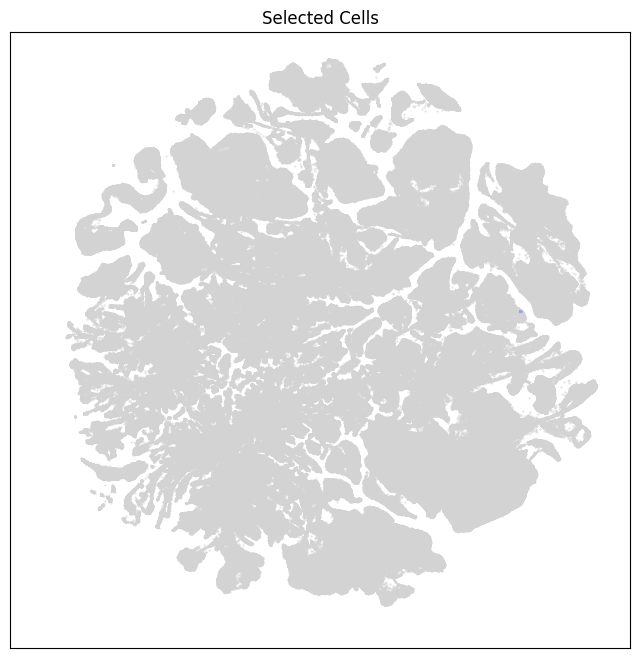

In [32]:
fig, ax = plot_umap_with_taxonomy_selection(
    cell_with_genes,
    cc_value='#D3D3D3'
)
plot_umap_with_taxonomy_selection(
    abc_selected_cell_with_genes,
    cc_column='subclass_color',
    cell_type_taxon=['subclass', '022 L5 ET CTX Glut'],
    fig=fig,
    ax=ax
)
res = ax.set_title(f"Selected Cells")

For a more in-depth demo of using cells selected from the ABC Atlas visualization see the Using cells selected in the [ABC Atlas with Gene Expression data](https://alleninstitute.github.io/abc_atlas_access/notebooks/abc_atlas_selection_example.html) notebook on the ABC Atlas Access website.